# Intro to Neural Networks

Colab link: https://colab.research.google.com/notebooks/mlcc/intro_to_neural_nets.ipynb

**Learning Objectives:**
  * Define a neural network (NN) and its hidden layers using the TensorFlow `DNNRegressor` class
  * Train a neural network to learn nonlinearities in a dataset and achieve better performance than a linear regression model

In the previous exercises, we used synthetic features to help our model incorporate nonlinearities.

One important set of nonlinearities was around latitude and longitude, but there may be others.

We'll also switch back, for now, to a standard regression task, rather than the logistic regression task from the previous exercise. That is, we'll be predicting `median_house_value` directly.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')

chdf = chdf.reindex(np.random.permutation(chdf.index))

In [0]:
def preprocess_features(df):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = df[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = ( df["total_rooms"] / df["population"] )

  # Normalising the features:
  processed_features -= processed_features.mean()
  processed_features /= processed_features.std()

  return processed_features

In [0]:
def preprocess_targets(df):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = ( df["median_house_value"] / 1000.0 )

  return output_targets

In [0]:
def TrainValTestDataSplit(feat_df, targ_df, train_percentage, val_percentage, test_percentage):

  # Data reshuffled randomly, just in case it hasn't been done yet:
  my_index = np.random.permutation(feat_df.index)
  feat_df = feat_df.reindex(my_index)
  targ_df = targ_df.reindex(my_index)

  # Training, Validation and Test dataset sizes:
  m_train = int(train_percentage*feat_df.shape[0])
  m_test = int(test_percentage*feat_df.shape[0])
  m_val = feat_df.shape[0] - m_train - m_test


  # Splitting DF into training and validation sets:
  training_examples = feat_df.head(m_train)
  training_targets = targ_df.head(m_train)
 
  validation_examples = feat_df.iloc[m_train:m_train+m_val] 
  validation_targets = targ_df.iloc[m_train:m_train+m_val]

  test_examples = feat_df.tail(m_test)  # we take the last examples using the tail command
  test_targets = targ_df.tail(m_test)

  return training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets


In [0]:
# Loading the data:
chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')
chdf = chdf.reindex(np.random.permutation(chdf.index))


# Processing the data:
pchdf = preprocess_features(chdf)  # def preprocess_features
ochdf = preprocess_targets(chdf)

print(pchdf.head())
print(ochdf.head())


# Chosen features:
# chosen_features = ['households', 'longitude', 'latitude', 'housing_median_age', 'median_income', 'rooms_per_person']
# pchdf = pchdf[chosen_features]


# Binning 'Latitude' feature:   # bucketised in feature columns
# pchdf = BinFeature(pchdf, 'latitude', [-2, 3])   # def BinFeature

# display.display(pchdf.head())


# Splitting the dataframe (total must sum 1!!!):
train_percentage = 0.75
val_percentage = 0.15
test_percentage = 0.10

[training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets] = TrainValTestDataSplit(pchdf, ochdf, train_percentage, val_percentage, test_percentage)  # def TrainValTestDataSplit


# Describing the different data sets:
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Test examples summary:")
display.display(test_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())

       latitude  longitude  ...  median_income  rooms_per_person
8807       -0.7        0.5  ...            0.7               0.1
12774       1.9       -1.1  ...            0.2               0.5
5945       -0.7        0.7  ...           -0.7              -1.0
14957       1.2       -1.3  ...           -0.1              -0.2
7364       -0.7        0.6  ...            0.2               1.0

[5 rows x 9 columns]
       median_house_value
8807                243.0
12774               125.2
5945                131.9
14957               131.6
7364                385.9
Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0
mean,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.4,-2.4,-2.2,-1.2,-1.3,-1.2,-1.3,-1.8,-1.7
25%,-0.8,-1.1,-0.8,-0.5,-0.6,-0.6,-0.6,-0.7,-0.4
50%,-0.7,0.5,0.0,-0.2,-0.2,-0.2,-0.2,-0.2,-0.0
75%,1.0,0.8,0.7,0.2,0.3,0.3,0.3,0.5,0.3
max,3.0,2.6,1.9,16.2,14.0,29.8,14.5,5.8,45.5


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0
mean,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.1,1.0,1.0,1.1,1.0,1.3
min,-1.4,-2.3,-2.2,-1.2,-1.3,-1.2,-1.3,-1.8,-1.6
25%,-0.8,-1.1,-0.8,-0.5,-0.6,-0.6,-0.6,-0.7,-0.4
50%,-0.6,0.5,-0.0,-0.2,-0.3,-0.2,-0.3,-0.2,-0.0
75%,1.0,0.8,0.7,0.2,0.2,0.2,0.2,0.5,0.3
max,2.9,2.5,1.9,13.5,11.3,12.3,11.8,5.8,33.7


Test examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0
mean,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,0.9,0.9,1.0,0.9
min,-1.4,-2.3,-2.1,-1.2,-1.3,-1.2,-1.3,-1.8,-1.6
25%,-0.8,-1.1,-0.8,-0.5,-0.6,-0.6,-0.6,-0.7,-0.4
50%,-0.6,0.5,-0.0,-0.3,-0.3,-0.2,-0.3,-0.2,-0.0
75%,1.0,0.8,0.7,0.2,0.2,0.2,0.3,0.5,0.3
max,2.9,2.5,1.9,12.7,9.1,10.0,8.9,5.8,13.1


Training targets summary:


,median_house_value
count,12750.0
mean,207.4
std,116.0
min,15.0
25%,120.3
50%,180.1
75%,265.4
max,500.0


Validation targets summary:


,median_house_value
count,2550.0
mean,206.7
std,114.8
min,27.5
25%,118.6
50%,182.6
75%,260.9
max,500.0


Test targets summary:


,median_house_value
count,1700.0
mean,207.5
std,118.0
min,30.0
25%,116.2
50%,178.4
75%,268.0
max,500.0


## Building a Neural Network

The NN is defined by the [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor) class.

Use **`hidden_units`** to define the structure of the NN.  The `hidden_units` argument provides a list of ints, where each int corresponds to a hidden layer and indicates the number of nodes in it.  For example, consider the following assignment:

`hidden_units=[3,10]`

The preceding assignment specifies a neural net with two hidden layers:

* The first hidden layer contains 3 nodes.
* The second hidden layer contains 10 nodes.

If we wanted to add more layers, we'd add more ints to the list. For example, `hidden_units=[10,20,30,40]` would create four layers with ten, twenty, thirty, and forty units, respectively.

By default, all hidden layers will use **ReLu** activation and will be fully connected.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

In [0]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
      # activation_fn= relu,  # sigmoid
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], batch_size=1, num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"], batch_size=1, num_epochs=1, shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(training_predictions, training_targets) )
    validation_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(validation_predictions, validation_targets) )
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.grid()
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(training_predictions, training_targets.values, '.', label='training')
  plt.plot(validation_predictions, validation_targets.values, '.', label='validation')
  plt.ylabel("example labels")
  plt.xlabel("predictions")
  plt.title("Predictions vs. Real Targets")
  plt.grid()
  plt.legend()
  plt.show()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

## Task 1: Train a NN Model

**Adjust hyperparameters, aiming to drop RMSE below 110.**

Run the following block to train a NN model.  

Recall that in the linear regression exercise with many features, an RMSE of 110 or so was pretty good.  We'll aim to beat that.

Your task here is to modify various learning settings to improve accuracy on validation data.

Overfitting is a real potential hazard for NNs.  You can look at the gap between loss on training data and loss on validation data to help judge if your model is starting to overfit. If the gap starts to grow, that is usually a sure sign of overfitting.

Because of the number of different possible settings, it's strongly recommended that you take notes on each trial to help guide your development process.

Also, when you get a good setting, try running it multiple times and see how repeatable your result is. NN weights are typically initialized to small random values, so you should see differences from run to run.

Training model...
RMSE (on training data):
  period 00 : 220.34
  period 01 : 145.66
  period 02 : 77.52
  period 03 : 72.10
  period 04 : 69.51
  period 05 : 68.17
  period 06 : 67.47
  period 07 : 67.03
  period 08 : 66.54
  period 09 : 66.26
Model training finished.


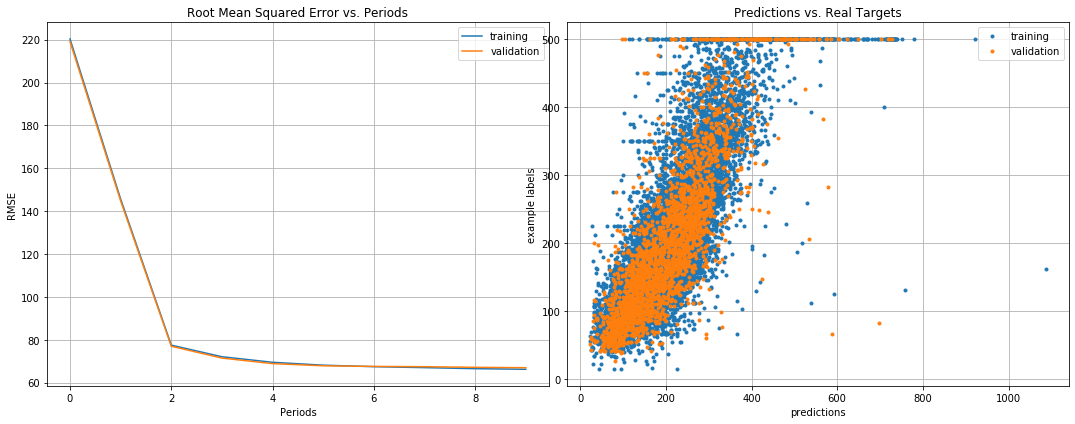

Final RMSE (on training data):   66.26
Final RMSE (on validation data): 67.00


In [0]:
# Call the training model:
learning_rate = 0.001   # 0.0007
steps = 8000   # 5000
batch_size = 100   # 70
hidden_units = [20,5]    # [10,10]  # units for each hidden layer
# Performance improves when normalising the features!!!

dnn_regression = train_nn_regression_model(
    learning_rate=learning_rate,
    steps=steps,
    batch_size=batch_size,
    hidden_units=hidden_units,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

RMSE (on training data):   66.257
RMSE (on validation data): 66.999
RMSE (on test data):       68.711


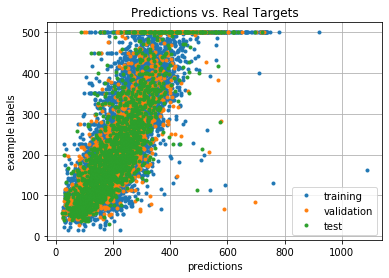

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

In [0]:
# Training, Validation and Test predictions:
predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], batch_size=1, num_epochs=1, shuffle=False)
training_predictions = dnn_regression.predict(input_fn=predict_training_input_fn)
training_predictions = np.array([item['predictions'][0] for item in training_predictions])

predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"], batch_size=1, num_epochs=1, shuffle=False)
validation_predictions = dnn_regression.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

predict_test_input_fn = lambda: my_input_fn(test_examples, test_targets["median_house_value"], batch_size=1, num_epochs=1, shuffle=False)
test_predictions = dnn_regression.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

# Loss RMSE:
training_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(training_predictions, training_targets) )
validation_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(validation_predictions, validation_targets) )
test_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(test_predictions, test_targets) )

print('RMSE (on training data):   %0.3f' %(training_root_mean_squared_error))
print('RMSE (on validation data): %0.3f' %(validation_root_mean_squared_error))
print('RMSE (on test data):       %0.3f' %(test_root_mean_squared_error))

plt.plot(training_predictions, training_targets.values, '.', label='training')
plt.plot(validation_predictions, validation_targets.values, '.', label='validation')
plt.plot(test_predictions, test_targets.values, '.', label='test')
plt.ylabel("example labels")
plt.xlabel("predictions")
plt.title("Predictions vs. Real Targets")
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize=(15,6))


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.4,-2.4,-2.2,-1.2,-1.3,-1.2,-1.3,-1.8,-1.7
25%,-0.8,-1.1,-0.8,-0.5,-0.6,-0.6,-0.6,-0.7,-0.4
50%,-0.6,0.5,0.0,-0.2,-0.3,-0.2,-0.2,-0.2,-0.0
75%,1.0,0.8,0.7,0.2,0.3,0.3,0.3,0.5,0.3
max,3.0,2.6,1.9,16.2,14.0,29.8,14.5,5.8,45.5


,median_house_value
count,17000.0
mean,207.3
std,116.0
min,15.0
25%,119.4
50%,180.4
75%,265.0
max,500.0


RMSE (on training data):   66.257
RMSE (on validation data): 66.999
RMSE (on test data):       66.618


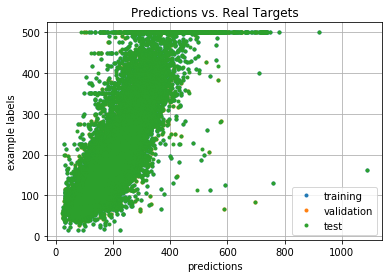

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

In [0]:
# Test loss on specific Test dataset:

chdf_test = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

# Processing the test data:
pchdf_test = preprocess_features(chdf)  # def preprocess_features
ochdf_test = preprocess_targets(chdf)

test_examples = pchdf_test
test_targets = ochdf_test

display.display(test_examples.describe())
display.display(test_targets.describe())

# Test predictions:
predict_test_input_fn = lambda: my_input_fn(test_examples, test_targets["median_house_value"], batch_size=1, num_epochs=1, shuffle=False)
test_predictions = dnn_regression.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

# Loss RMSE:
test_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(test_predictions, test_targets) )

print('RMSE (on training data):   %0.3f' %(training_root_mean_squared_error))
print('RMSE (on validation data): %0.3f' %(validation_root_mean_squared_error))
print('RMSE (on test data):       %0.3f' %(test_root_mean_squared_error))

plt.plot(training_predictions, training_targets.values, '.', label='training')
plt.plot(validation_predictions, validation_targets.values, '.', label='validation')
plt.plot(test_predictions, test_targets.values, '.', label='test')
plt.ylabel("example labels")
plt.xlabel("predictions")
plt.title("Predictions vs. Real Targets")
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize=(15,6))
